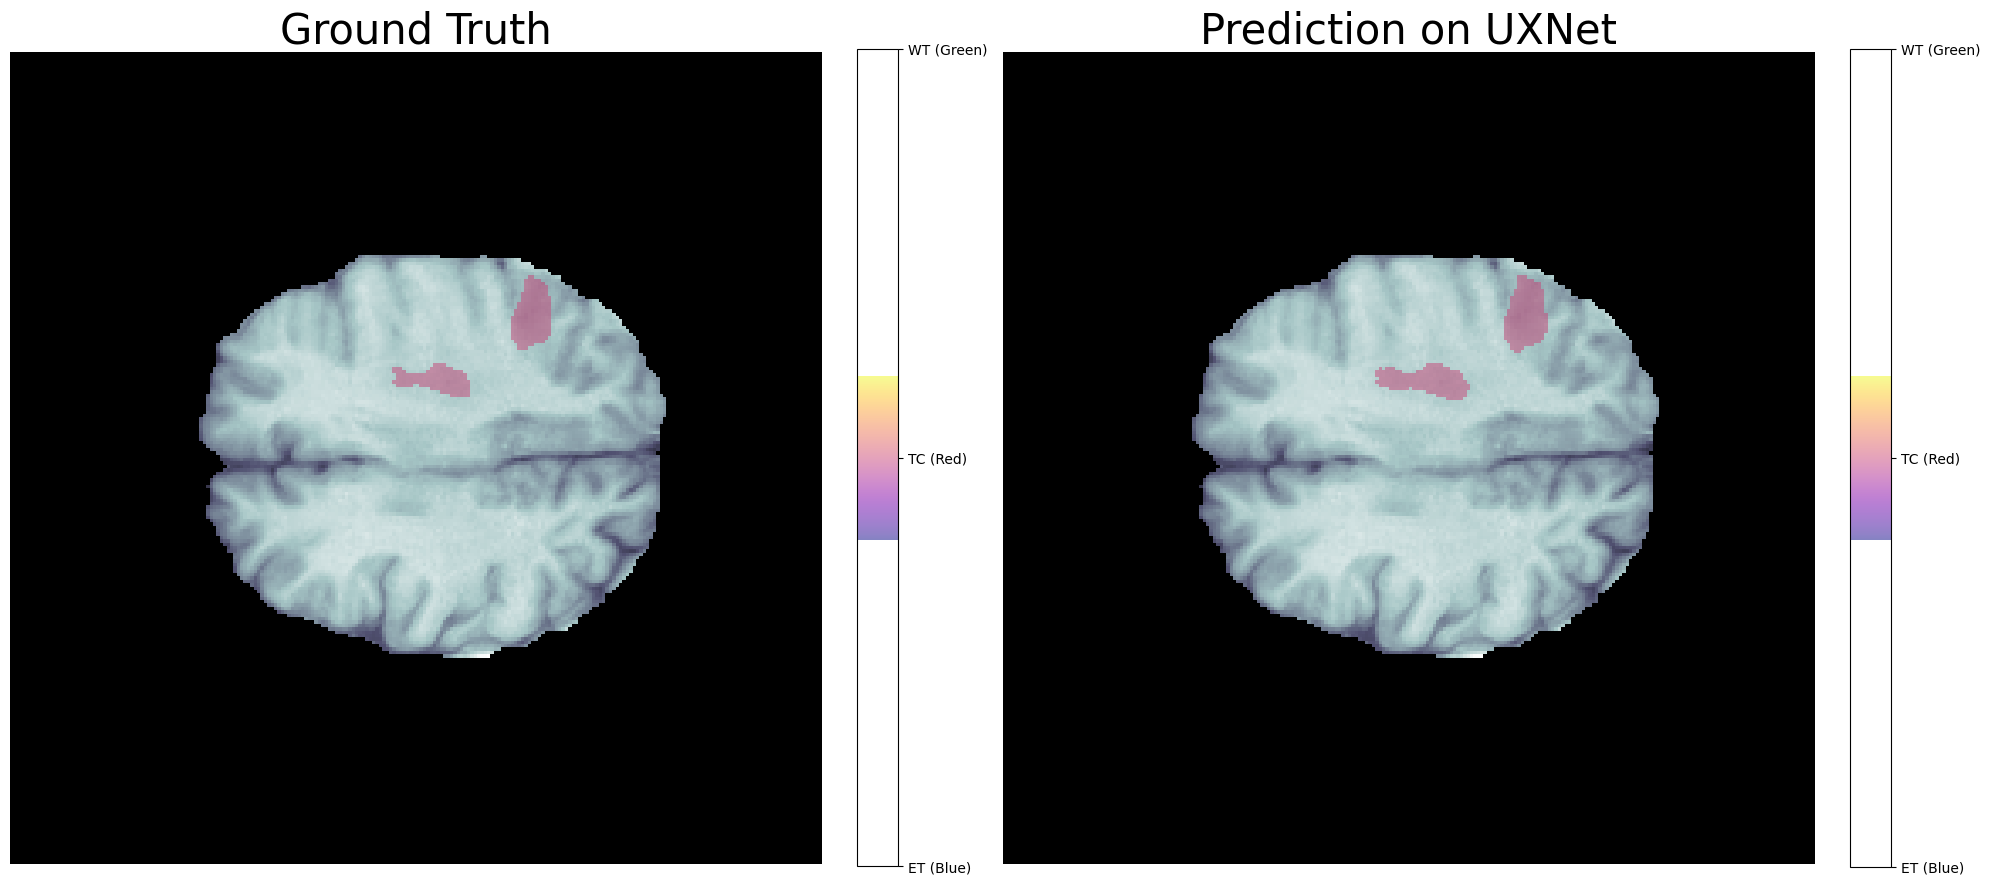

interactive(children=(IntSlider(value=77, description='Slice:', max=154), Dropdown(description='Axis:', index=…

In [17]:
# -*- coding: UTF-8 -*-
'''
================================================
*      CREATE ON: 2025/01/14 22:11:40
*      AUTHOR: @Junyin Xiong
*      DESCRIPTION: 可视化nii结果
*      VERSION: v1.0
=================================================
'''

import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from ipywidgets import interact, IntSlider, Dropdown

def get_paths_dict(patient_dir: str) -> dict:
    """
    获取患者目录下的所有文件路径，并按模态分类。
    """
    paths_dict = {}
    filenames = os.listdir(patient_dir)
    for filename in filenames:
        if not filename.endswith('.nii.gz'):  # 确保文件是 NIfTI 格式
            continue
        modal = filename.split('.')[0].split('_')[-1]
        path = os.path.join(patient_dir, filename)
        paths_dict[modal] = path
    return paths_dict

def get_data_dict(paths_dict: dict) -> dict:
    """
    加载所有模态的数据。
    """
    data_dict = {}
    for modal, path in paths_dict.items():
        if not os.path.exists(path):  # 检查文件是否存在
            raise FileNotFoundError(f"File not found: {path}")
        data_ndarray = nib.load(path).get_fdata()
        data_dict[modal] = data_ndarray
    return data_dict

def get_slice_dict(data_dict: dict, slice_num: int, axis: str = 'z') -> tuple:
    """
    提取指定切片的原始图像、真实掩膜和预测结果，并生成子区域的掩膜和预测结果。
    """
    sub_areas = ['ET', 'TC', 'WT']
    slices = {}
    subarea_slice_mask = {}
    subarea_slice_pred = {}

    # 提取原始图像、真实掩膜和预测结果
    if axis == 'x':
        slices['original'] = data_dict['t1'][slice_num, :, :]
        slices['mask'] = data_dict['mask'][slice_num, :, :]
        slices['pred'] = data_dict['pred'][slice_num, :, :]
    elif axis == 'y':
        slices['original'] = data_dict['t1'][:, slice_num, :]
        slices['mask'] = data_dict['mask'][:, slice_num, :]
        slices['pred'] = data_dict['pred'][:, slice_num, :]
    elif axis == 'z':
        slices['original'] = data_dict['t1'][:, :, slice_num]
        slices['mask'] = data_dict['mask'][:, :, slice_num]
        slices['pred'] = data_dict['pred'][:, :, slice_num]
    else:
        raise ValueError("Invalid axis. Choose from 'x', 'y', or 'z'.")

    # 生成子区域的掩膜和预测结果
    for label, sub_area in enumerate(sub_areas):
        subarea_slice_mask[f'{sub_area} on Mask'] = np.where(slices['mask'] == label + 1, label + 1, 0)
        subarea_slice_pred[f'{sub_area} on Pred'] = np.where(slices['pred'] == label + 1, label + 1, 0)

    return slices, subarea_slice_mask, subarea_slice_pred

def _plot_slice(ax, original: np.ndarray, overlay: np.ndarray, title: str, cmap_overlay: ListedColormap, alpha: float = 0.5):
    """
    辅助函数：绘制原始图像和叠加的掩膜。
    """
    ax.imshow(original, cmap='bone')
    im = ax.imshow(np.ma.masked_where(overlay == 0, overlay), cmap=cmap_overlay, alpha=alpha)
    ax.set_title(title, fontsize=30)
    ax.axis('off')
    return im

def show_mapped_slice_mask_to_data(slices: dict, addition: str, cmap: ListedColormap):
    """
    显示真实掩膜和预测结果的对比图，并添加 colorbar。
    """
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    
    # 绘制真实掩膜
    im1 = _plot_slice(axs[0], slices['original'], slices['mask'], 'Ground Truth', cmap_overlay=cmap)
    
    # 绘制预测结果
    im2 = _plot_slice(axs[1], slices['original'], slices['pred'], f'Prediction on {addition}', cmap_overlay=cmap)
    
    # 添加 colorbar
    cbar1 = fig.colorbar(im1, ax=axs[0], orientation='vertical', fraction=0.046, pad=0.04)
    cbar2 = fig.colorbar(im2, ax=axs[1], orientation='vertical', fraction=0.046, pad=0.04)
    
    # 设置 colorbar 的标签
    cbar1.set_ticks([1, 2, 3])
    cbar1.set_ticklabels(['ET (Blue)', 'TC (Red)', 'WT (Green)'])
    cbar2.set_ticks([1, 2, 3])
    cbar2.set_ticklabels(['ET (Blue)', 'TC (Red)', 'WT (Green)'])
    
    plt.tight_layout()
    plt.show()

def interactive_slice_viewer(data_dict: dict, addition: str = 'UNet', cmap: ListedColormap = None):
    """
    在 Jupyter Notebook 中交互式查看切片。
    """
    def update(slice_num, axis):
        slices, _, _ = get_slice_dict(data_dict, slice_num, axis)
        show_mapped_slice_mask_to_data(slices, addition, cmap)
    
    # 获取最大切片数
    max_slice_x = data_dict['t1'].shape[0] - 1
    max_slice_y = data_dict['t1'].shape[1] - 1
    max_slice_z = data_dict['t1'].shape[2] - 1
    
    # 创建轴选择控件
    axis_selector = Dropdown(options=['x', 'y', 'z'], value='z', description='Axis:')
    
    # 创建切片滑块控件
    slice_slider = IntSlider(min=0, max=max_slice_z, step=1, value=max_slice_z // 2, description='Slice:')
    
    # 动态更新滑块的最大值
    def update_slice_slider(change):
        if change['new'] == 'x':
            slice_slider.max = max_slice_x
        elif change['new'] == 'y':
            slice_slider.max = max_slice_y
        elif change['new'] == 'z':
            slice_slider.max = max_slice_z
    
    axis_selector.observe(update_slice_slider, names='value')
    
    # 交互式控件
    interact(update, slice_num=slice_slider, axis=axis_selector)

def process_and_visualize(patient_dir: str, slice_num: int, addition: str = 'UNet', axis: str = 'z', interactive: bool = False, cmap: ListedColormap = None):
    """
    串联所有函数，通过接受 NIfTI 文件路径直接输出结果。
    
    参数:
    patient_dir: 患者目录路径。
    slice_num: 要显示的切片编号。
    addition: 网络名称，用于标题显示。
    axis: 切片轴 ('x', 'y', 'z')。
    interactive: 是否在 Jupyter Notebook 中交互式查看切片。
    cmap: 用于显示 mask 和 pred 的自定义颜色映射。
    """
    # 1. 获取文件路径
    paths_dict = get_paths_dict(patient_dir)
    
    # 2. 加载数据
    data_dict = get_data_dict(paths_dict)
    
    # 3. 提取切片
    slices, subarea_slice_mask, subarea_slice_pred = get_slice_dict(data_dict, slice_num, axis)
    
    # 4. 显示真实掩膜和预测结果的对比图
    show_mapped_slice_mask_to_data(slices, addition, cmap)
    
    # 5. 在 Jupyter Notebook 中交互式查看切片
    if interactive:
        interactive_slice_viewer(data_dict, addition, cmap)

if __name__ == "__main__":
    # 示例调用
    patient_dir = '/root/workspace/VoxelMedix/output/UXNET/BraTS2021_00810'
    slice_num = 100  # 选择要显示的切片编号
    addition = 'UXNet'  # 网络名称
    axis = 'z'  # 切片轴 ('x', 'y', 'z')
    interactive = True  # 是否在 Jupyter Notebook 中交互式查看切片

    # 自定义颜色映射
    # cmap = ListedColormap(['black', 'blue', 'red', 'green'])  # 黑色背景，蓝色为 ET，红色为 TC，绿色为 WT
    cmap = 'plasma'
    process_and_visualize(patient_dir, slice_num, addition, axis, interactive, cmap)

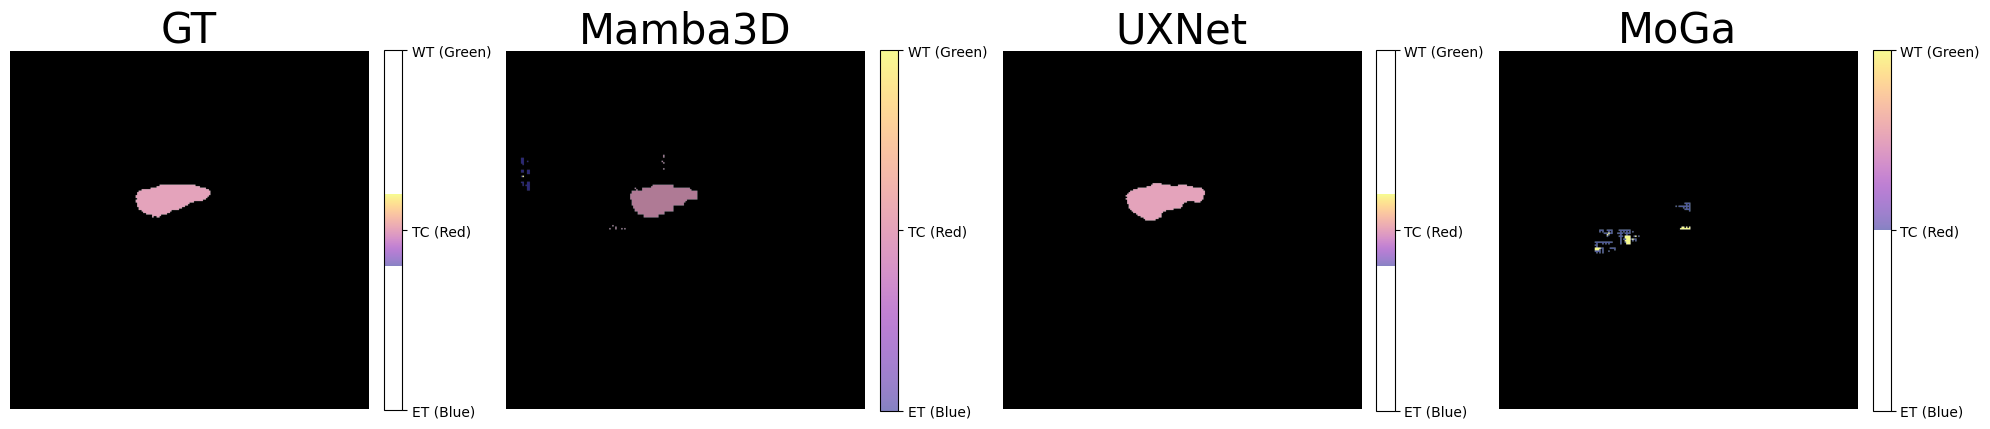

interactive(children=(IntSlider(value=77, description='Slice:', max=154), Dropdown(description='Axis:', index=…

In [1]:
# -*- coding: UTF-8 -*-
'''
================================================
*      CREATE ON: 2025/01/14 22:11:40
*      AUTHOR: @Junyin Xiong
*      DESCRIPTION: 可视化nii结果
*      VERSION: v1.0
=================================================
'''

import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from ipywidgets import interact, IntSlider, Dropdown

class NIfTIVisualizer:
    def __init__(self, data_dict: dict):
        """
        初始化 NIfTI 可视化器。
        
        参数:
        data_dict: 包含模型名称和对应 NIfTI 文件路径的字典。
        """
        self.data_dict = data_dict
        self.models = list(data_dict.keys())
        self.cmap = ListedColormap(['black', 'blue', 'red', 'green'])  # 默认颜色映射

    def get_data_dict(self) -> dict:
        """
        加载所有模型的数据。
        """
        loaded_data = {}
        for model, path in self.data_dict.items():
            if not os.path.exists(path):  # 检查文件是否存在
                raise FileNotFoundError(f"File not found: {path}")
            data_ndarray = nib.load(path).get_fdata()
            loaded_data[model] = data_ndarray
        return loaded_data

    def get_slice_dict(self, loaded_data: dict, slice_num: int, axis: str = 'z') -> dict:
        """
        提取指定切片的原始图像、真实掩膜和预测结果。
        """
        slices = {}
        for model, data in loaded_data.items():
            if axis == 'x':
                slices[model] = data[slice_num, :, :]
            elif axis == 'y':
                slices[model] = data[:, slice_num, :]
            elif axis == 'z':
                slices[model] = data[:, :, slice_num]
            else:
                raise ValueError("Invalid axis. Choose from 'x', 'y', or 'z'.")
        return slices

    def _plot_slice(self, ax, original: np.ndarray, overlay: np.ndarray, title: str, cmap_overlay: ListedColormap, alpha: float = 0.5):
        """
        辅助函数：绘制原始图像和叠加的掩膜。
        """
        ax.imshow(original, cmap='bone')
        im = ax.imshow(np.ma.masked_where(overlay == 0, overlay), cmap=cmap_overlay, alpha=alpha)
        ax.set_title(title, fontsize=30)
        ax.axis('off')
        return im

    def show_mapped_slice(self, slices: dict, cmap: ListedColormap = None):
        """
        显示不同模型的切片对比图，并添加 colorbar。
        """
        if cmap is None:
            cmap = self.cmap
        
        fig, axs = plt.subplots(1, len(slices), figsize=(20, 10))
        
        for i, (model, slice_data) in enumerate(slices.items()):
            im = self._plot_slice(axs[i], slice_data, slice_data, model, cmap_overlay=cmap)
            cbar = fig.colorbar(im, ax=axs[i], orientation='vertical', fraction=0.046, pad=0.04)
            cbar.set_ticks([1, 2, 3])
            cbar.set_ticklabels(['ET (Blue)', 'TC (Red)', 'WT (Green)'])
        plt.tight_layout()
        plt.show()

    def interactive_slice_viewer(self, loaded_data: dict, cmap: ListedColormap = None):
        """
        在 Jupyter Notebook 中交互式查看切片。
        """
        if cmap is None:
            cmap = self.cmap
        
        def update(slice_num, axis):
            slices = self.get_slice_dict(loaded_data, slice_num, axis)
            self.show_mapped_slice(slices, cmap)
        
        # 获取最大切片数
        max_slice_x = loaded_data[self.models[0]].shape[0] - 1
        max_slice_y = loaded_data[self.models[0]].shape[1] - 1
        max_slice_z = loaded_data[self.models[0]].shape[2] - 1
        
        # 创建轴选择控件
        axis_selector = Dropdown(options=['x', 'y', 'z'], value='z', description='Axis:')
        
        # 创建切片滑块控件
        slice_slider = IntSlider(min=0, max=max_slice_z, step=1, value=max_slice_z // 2, description='Slice:')
        
        # 动态更新滑块的最大值
        def update_slice_slider(change):
            if change['new'] == 'x':
                slice_slider.max = max_slice_x
            elif change['new'] == 'y':
                slice_slider.max = max_slice_y
            elif change['new'] == 'z':
                slice_slider.max = max_slice_z
        
        axis_selector.observe(update_slice_slider, names='value')
        
        # 交互式控件
        interact(update, slice_num=slice_slider, axis=axis_selector)

    def process_and_visualize(self, slice_num: int, axis: str = 'z', interactive: bool = False, cmap: ListedColormap = None):
        """
        串联所有函数，通过接受 NIfTI 文件路径直接输出结果。
        
        参数:
        slice_num: 要显示的切片编号。
        axis: 切片轴 ('x', 'y', 'z')。
        interactive: 是否在 Jupyter Notebook 中交互式查看切片。
        cmap: 用于显示 mask 和 pred 的自定义颜色映射。
        """
        # 1. 加载数据
        loaded_data = self.get_data_dict()
        
        # 2. 提取切片
        slices = self.get_slice_dict(loaded_data, slice_num, axis)
        
        # 3. 显示切片对比图
        self.show_mapped_slice(slices, cmap)
        
        # 4. 在 Jupyter Notebook 中交互式查看切片
        if interactive:
            self.interactive_slice_viewer(loaded_data, cmap)

if __name__ == "__main__":
    # 示例调用
    data_dict = {
        'GT':           '/root/workspace/VoxelMedix/output/Mamba3d/BraTS2021_00303/BraTS2021_00303_test_input_mask.nii.gz',
        'Mamba3D':      '/root/workspace/VoxelMedix/output/Mamba3d/BraTS2021_00303/BraTS2021_00303_test_pred.nii.gz',
        'UXNet':         '/root/workspace/VoxelMedix/output/UXNET/BraTS2021_00303/BraTS2021_00303_test_pred.nii.gz',
        'MoGa':         '/root/workspace/VoxelMedix/output/MogaNet/2025-01-15_15-00-19/BraTS2021_00303/BraTS2021_00303_test_pred.nii.gz',
    }   
    
    slice_num = 100  # 选择要显示的切片编号
    axis = 'z'  # 切片轴 ('x', 'y', 'z')
    interactive = True  # 是否在 Jupyter Notebook 中交互式查看切片

    # 自定义颜色映射
    # cmap = ListedColormap(['black', 'blue', 'red', 'green'])  # 黑色背景，蓝色为 ET，红色为 TC，绿色为 WT
    cmap = 'plasma'
    
    visualizer = NIfTIVisualizer(data_dict)
    visualizer.process_and_visualize(slice_num, axis, interactive, cmap)